In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import time
from itertools import combinations

In [1]:
import pandas as pd

# 加载 Online Retail 数据集
online_retail_df = pd.read_excel('Online Retail.xlsx')


In [2]:
# 计算唯一项目数
unique_items_count = online_retail_df['Description'].nunique()
print(f'Unique Items Count: {unique_items_count}')

# 计算交易数量
transactions_count = online_retail_df['InvoiceNo'].nunique()
print(f'Transactions Count: {transactions_count}')

Unique Items Count: 4223
Transactions Count: 25900


In [7]:
import numpy as np
import pandas as pd

# 创建数据集字典
datasets = {}

def create_datasets(online_retail_df, fixed='transactions', fixed_count=1000, varying_counts=[1000, 2000, 4000]):
    # 数据清洗：去除缺失值和重复项
    online_retail_df = online_retail_df.dropna(subset=['Description'])  # 去除描述为空的行
    online_retail_df = online_retail_df.drop_duplicates(subset=['InvoiceNo', 'Description'])  # 去除重复项

    if fixed == 'transactions':
        # 固定交易数量，变化唯一商品数量
        for num_unique_items in varying_counts:
            sampled_items = np.random.choice(online_retail_df['Description'].unique(), num_unique_items, replace=False)
            filtered_data = online_retail_df[online_retail_df['Description'].isin(sampled_items)]
            
            unique_transactions = filtered_data['InvoiceNo'].unique()
            sampled_transactions = np.random.choice(unique_transactions, fixed_count, replace=False)
            sampled_data = filtered_data[filtered_data['InvoiceNo'].isin(sampled_transactions)]
            datasets[f'fixed_transactions_unique_{num_unique_items}'] = sampled_data
    
    elif fixed == 'unique_items':
        # 按出现频率选择固定数量的唯一商品
        item_counts = online_retail_df['Description'].value_counts()
        top_items = item_counts.head(fixed_count).index  # 选择最常出现的商品
        filtered_data = online_retail_df[online_retail_df['Description'].isin(top_items)]
        
        # 确保仅包含所选择的唯一商品
        filtered_data = filtered_data[filtered_data['Description'].isin(top_items)]
        
        # 变化交易数量
        for num_transactions in varying_counts:
            unique_transactions = filtered_data['InvoiceNo'].unique()
            
            # 如果样本不足所需交易数量，则跳过
            if len(unique_transactions) < num_transactions:
                print(f"无法提供 {num_transactions} 笔交易的数据集，因为交易数量不足。")
                continue
            
            # 抽样指定数量的交易
            sampled_transactions = np.random.choice(unique_transactions, num_transactions, replace=False)
            sampled_data = filtered_data[filtered_data['InvoiceNo'].isin(sampled_transactions)]
            datasets[f'fixed_unique_items_transactions_{num_transactions}'] = sampled_data

# 调用函数创建数据集：可以选择固定方式为 'transactions' 或 'unique_items'
create_datasets(online_retail_df, fixed='transactions', fixed_count=1000, varying_counts=[1000, 2000, 4000])
create_datasets(online_retail_df, fixed='unique_items', fixed_count=800, varying_counts=[1000, 2000, 4000])

# 检查创建的数据集并显示基本统计信息
for key, df in datasets.items():
    print(f'Dataset: {key}, Shape: {df.shape}, Unique Items: {df["Description"].nunique()}, Transactions: {df["InvoiceNo"].nunique()}')


Dataset: fixed_transactions_unique_1000, Shape: (7117, 8), Unique Items: 740, Transactions: 1000
Dataset: fixed_transactions_unique_2000, Shape: (11569, 8), Unique Items: 1395, Transactions: 1000
Dataset: fixed_transactions_unique_4000, Shape: (19189, 8), Unique Items: 2763, Transactions: 1000
Dataset: fixed_unique_items_transactions_1000, Shape: (15993, 8), Unique Items: 800, Transactions: 1000
Dataset: fixed_unique_items_transactions_2000, Shape: (31508, 8), Unique Items: 800, Transactions: 2000
Dataset: fixed_unique_items_transactions_4000, Shape: (63434, 8), Unique Items: 800, Transactions: 4000


In [9]:
# 记录每个数据集的执行时间
execution_times = []

In [10]:
import time
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

# 创建一个列表来存储Apriori算法的执行时间
apriori_execution_times = []

# 定义抽样比例
sample_ratio = 0.005  # 使用 2% 的数据子集进行计算

for key, df in datasets.items():
    print(f"Processing dataset: {key}")
    
    # 从数据集中随机抽取一个子集
    df_sample = df.sample(frac=sample_ratio, random_state=42)
    print(f"Sampled {len(df_sample)} rows from the original {len(df)} rows.")

    # 数据预处理
    basket = df_sample.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
    # 将 basket 转换为布尔类型以提高性能
    basket = basket.applymap(lambda x: x > 0).astype(bool)

    # 根据数据规模动态调整支持度
    min_support = max(0.0005, 1 / len(df_sample['InvoiceNo'].unique()))
    min_threshold = 0.1

    print(f"Using min_support={min_support} and min_threshold={min_threshold}")

    # 记录频繁项集生成时间
    try:
        start_time = time.time()
        frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True, low_memory=True)
        itemset_time = time.time() - start_time

        # 检查频繁项集是否为空
        if frequent_itemsets.empty:
            print(f"No frequent itemsets found for {key} with min_support={min_support}")
            rule_time = 0  # 如果没有频繁项集，规则生成时间为 0
        else:
            print(f"Number of frequent itemsets for {key}: {len(frequent_itemsets)}")
            print(frequent_itemsets.head())  # 查看前几行频繁项集

            # 记录关联规则生成时间
            start_time = time.time()
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)
            rule_time = time.time() - start_time
            
            if rules.empty:
                print(f"No association rules found for {key} with confidence >= {min_threshold}")
                
                # 尝试用 lift 作为度量标准
                start_time = time.time()
                rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
                rule_time += time.time() - start_time  # 累加 lift 规则生成时间
                
                if not rules.empty:
                    print(f"Generated rules using lift metric: {len(rules)} rules")
                    print(rules[['antecedents', 'consequents']].head())
                else:
                    print("No rules generated even with lift metric.")
            else:
                print(f"Number of association rules for {key} with confidence >= {min_threshold}: {len(rules)}")
                print(rules[['antecedents', 'consequents']].head())
    except MemoryError:
        print(f"MemoryError: Unable to process dataset {key} with min_support={min_support}. Consider sampling the data or increasing min_support.")
        itemset_time = rule_time = 0  # 将时间设为 0 表示此数据集未处理

    # 将Apriori算法的执行时间记录到独立列表
    apriori_execution_times.append({
        'dataset': key,
        'itemset_time': itemset_time,
        'rule_time': rule_time,
        'total_time': itemset_time + rule_time
    })

# 转换为 DataFrame 以便于分析Apriori算法的执行时间
apriori_times_df = pd.DataFrame(apriori_execution_times)
print("\nApriori Execution Times for Each Dataset:")
print(apriori_times_df)


Processing dataset: fixed_transactions_unique_1000
Sampled 36 rows from the original 7117 rows.
Using min_support=0.029411764705882353 and min_threshold=0.1
Number of frequent itemsets for fixed_transactions_unique_1000: 34
    support                             itemsets
0  0.029412     (6 GIFT TAGS VINTAGE CHRISTMAS )
1  0.029412  (AIRLINE BAG VINTAGE JET SET BROWN)
2  0.029412                 (BLUE PUDDING SPOON)
3  0.029412        (CHILDRENS CUTLERY SPACEBOY )
4  0.029412     (CHRISTMAS METAL TAGS ASSORTED )
Number of association rules for fixed_transactions_unique_1000 with confidence >= 0.1: 4
                           antecedents                          consequents
0       (SET OF 3 NOTEBOOKS IN PARCEL)     (6 GIFT TAGS VINTAGE CHRISTMAS )
1     (6 GIFT TAGS VINTAGE CHRISTMAS )       (SET OF 3 NOTEBOOKS IN PARCEL)
2  (AIRLINE BAG VINTAGE JET SET BROWN)       (HOMEMADE JAM SCENTED CANDLES)
3       (HOMEMADE JAM SCENTED CANDLES)  (AIRLINE BAG VINTAGE JET SET BROWN)
Processing da

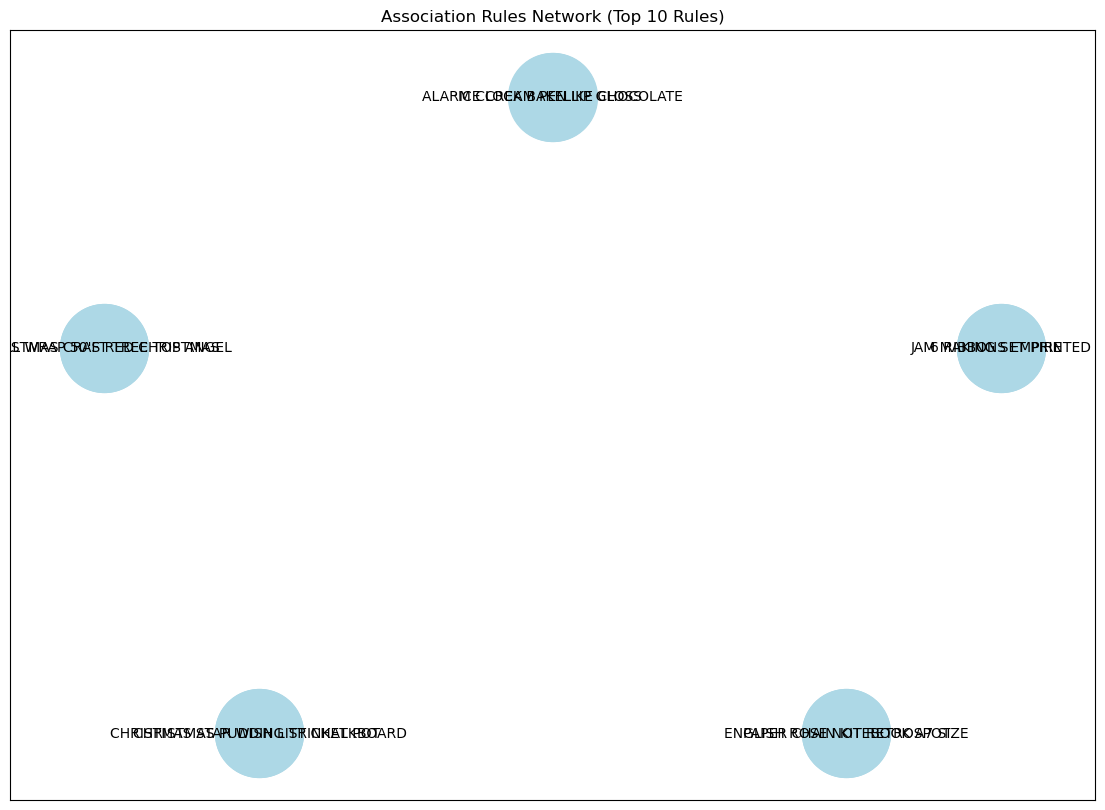

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_association_rules_network(rules, num_rules=10):
    G = nx.DiGraph()

    # 选择前 `num_rules` 条规则
    for _, row in rules.head(num_rules).iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(antecedent, consequent, weight=row['confidence'])

    # 使用 circular_layout 或 kamada_kawai_layout
    pos = nx.kamada_kawai_layout(G)

    # 增大图尺寸
    plt.figure(figsize=(14, 10))

    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='lightblue')

    # 绘制带有权重的边
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.6, edge_color='gray')

    # 显示置信度作为边的标签
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # 添加节点标签
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title("Association Rules Network (Top {} Rules)".format(num_rules))
    plt.show()

# 使用更少的规则生成网络图，例如前 5 条
plot_association_rules_network(rules, num_rules=10)


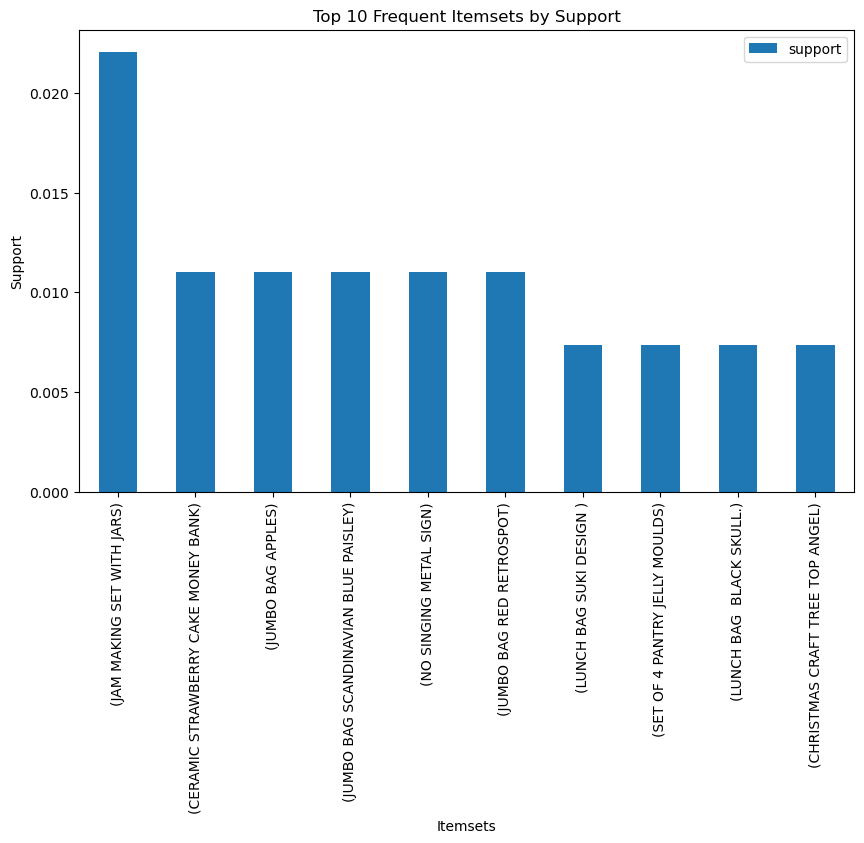

In [8]:
frequent_itemsets.sort_values(by='support', ascending=False).head(10).plot(
    x='itemsets', y='support', kind='bar', figsize=(10, 6))
plt.title("Top 10 Frequent Itemsets by Support")
plt.xlabel("Itemsets")
plt.ylabel("Support")
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from scipy.sparse import csr_matrix

def create_sparse_boolean_matrix(data, items):
    transactions = data.groupby('InvoiceNo')['Description'].apply(set).tolist()
    transaction_count = len(transactions)
    
    item_index = {item: idx for idx, item in enumerate(items)}
    row_indices = []
    col_indices = []
    
    for i, transaction in enumerate(transactions):
        for item in transaction:
            if item in item_index:
                row_indices.append(i)
                col_indices.append(item_index[item])
    
    boolean_matrix = csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)),
                                 shape=(transaction_count, len(items)))
    
    return boolean_matrix, item_index

def count_support(combo_indices, boolean_matrix):
    return boolean_matrix[:, combo_indices].sum(axis=1).A1.sum()

def is_frequent_subset(itemset, frequent_itemsets):
    """检查给定的项集的所有子集是否都是频繁的"""
    for r in range(1, len(itemset)):
        for subset in combinations(itemset, r):
            if subset not in frequent_itemsets:
                return False
    return True

def brute_force_association_rules(data, min_support, min_confidence, max_length):
    items = data['Description'].unique()
    boolean_matrix, item_index = create_sparse_boolean_matrix(data, items)
    transaction_count = boolean_matrix.shape[0]
    min_support_count = min_support * transaction_count
    frequent_itemsets = {}

    for r in range(1, min(len(items), max_length) + 1):
        candidates = list(combinations(items, r))
        found_new_itemset = False

        for combo in tqdm(candidates, desc=f"Processing itemsets of length {r}"):
            # 剪枝：仅在所有子集都是频繁的情况下计算支持
            if is_frequent_subset(combo, frequent_itemsets):
                combo_indices = [item_index[item] for item in combo]
                count = count_support(combo_indices, boolean_matrix)
                
                if count >= min_support_count:
                    frequent_itemsets[combo] = count / transaction_count
                    found_new_itemset = True

        if not found_new_itemset:
            print(f"No new frequent itemsets found for length {r}, stopping early.")
            break

    rules = []
    for itemset, support in tqdm(frequent_itemsets.items(), desc="Generating association rules"):
        if len(itemset) < 2:
            continue

        for r in range(1, len(itemset)):
            for antecedent in combinations(itemset, r):
                consequent = tuple(sorted(set(itemset) - set(antecedent)))
                antecedent_support = frequent_itemsets.get(antecedent, 0)
                consequent_support = frequent_itemsets.get(consequent, 0)

                if antecedent_support > 0:
                    confidence = support / antecedent_support
                    lift = confidence / (consequent_support if consequent_support > 0 else 1)  # Prevent division by zero
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedent': antecedent,
                            'consequent': consequent,
                            'support': support,
                            'confidence': confidence,
                            'lift': lift  # 添加提升度
                        })

    return frequent_itemsets, rules

def run_with_timeout(data, min_support, min_confidence, max_length, timeout):
    with ThreadPoolExecutor() as executor:
        future = executor.submit(brute_force_association_rules, data, min_support, min_confidence, max_length)
        try:
            return future.result(timeout=timeout)
        except TimeoutError:
            print("Execution exceeded the time limit for this dataset.")
            return {}, []  # Return empty results if timeout

# 设置最小支持度、置信度和最大长度
min_support = 0.0005
min_confidence = 0.1
max_length = 4

# 记录结果和执行时间
brute_force_results = {}
execution_times = {}

for key, df in datasets.items():
    print(f"Running brute force on dataset: {key}")
    
    # 随机抽取数据的       2% 以减轻内存压力
    subset_df = df.sample(frac=0.002, random_state=1)  # 降低抽样比例
    
    start_time = time.time()
    time_limit = 300  # 设置 3 分钟的时间限制
    frequent_itemsets, rules = run_with_timeout(subset_df, min_support, min_confidence, max_length, timeout=time_limit)
    end_time = time.time()

    brute_force_results[key] = {'frequent_itemsets': frequent_itemsets, 'rules': rules}
    execution_times[key] = end_time - start_time  # 记录每个数据集的执行时间

    # 将规则写入文件
    rules_df = pd.DataFrame(rules)
    rules_df.to_csv(f'{key}_rules.csv', index=False)

# 打印结果摘要
for dataset, result in brute_force_results.items():
    print(f"Dataset: {dataset}, Number of Frequent Itemsets: {len(result['frequent_itemsets'])}, Number of Rules: {len(result['rules'])}")

# 打印每个数据集的执行时间
for dataset, exec_time in execution_times.items():
    print(f"Time taken for {dataset}: {exec_time:.2f} seconds")


Running brute force on dataset: fixed_transactions_unique_1000


Generating association rules: 100%|█████████████████████████████████████████████| 1470/1470 [00:00<00:00, 32185.22it/s]


Running brute force on dataset: fixed_transactions_unique_2000


Generating association rules: 100%|█████████████████████████████████████████████| 9108/9108 [00:00<00:00, 25645.42it/s]


Running brute force on dataset: fixed_transactions_unique_4000


Generating association rules: 100%|███████████████████████████████████████████| 82992/82992 [00:04<00:00, 20527.44it/s]


Running brute force on dataset: fixed_unique_items_transactions_1000


Generating association rules: 100%|███████████████████████████████████████████| 41448/41448 [00:02<00:00, 15325.70it/s]


Running brute force on dataset: fixed_unique_items_transactions_2000


Generating association rules: 100%|█████████████████████████████████████████| 597618/597618 [00:50<00:00, 11852.51it/s]


Running brute force on dataset: fixed_unique_items_transactions_4000


Processing itemsets of length 4:  21%|███████▉                             | 1691156/7940751 [04:10<16:09, 6448.69it/s]

Execution exceeded the time limit for this dataset.


Generating association rules:  18%|██████▉                                | 1461978/8221710 [10:20<6:25:42, 292.10it/s]

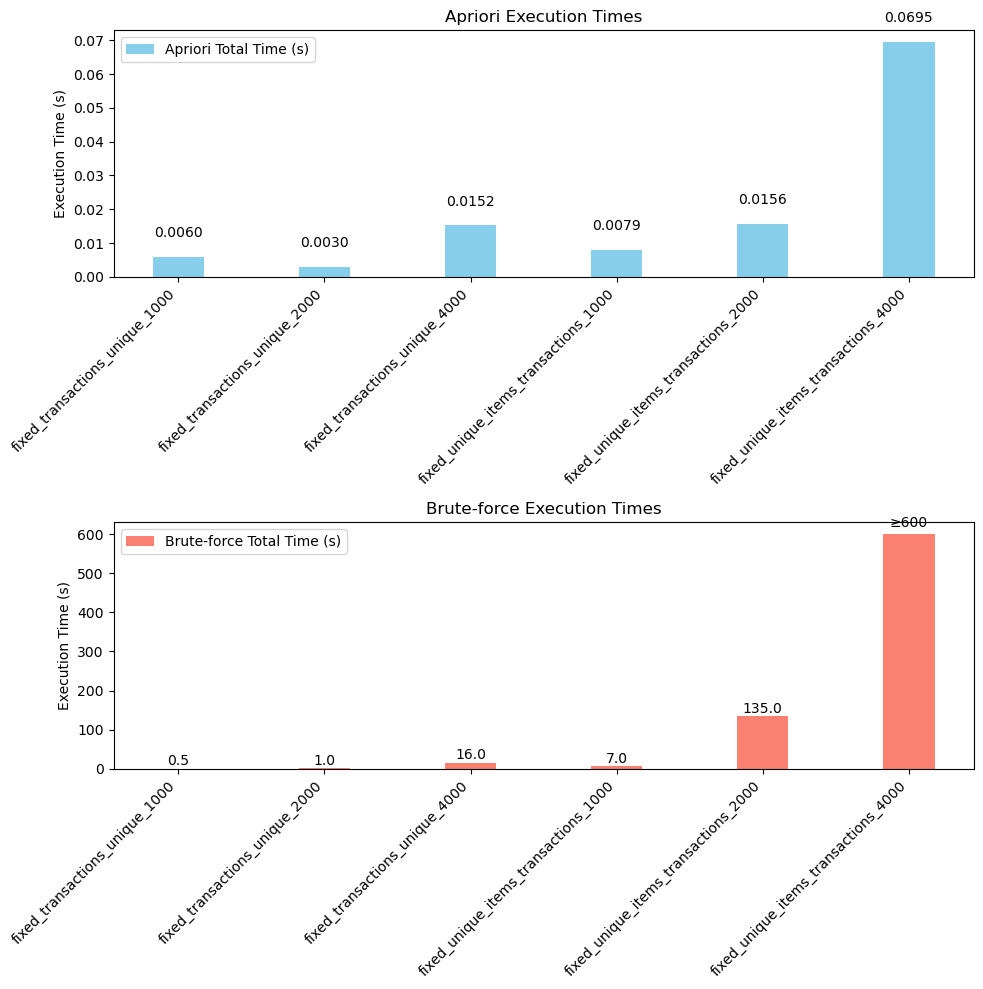

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for Apriori and Brute-force Execution Times
apriori_data = {
    'dataset': [
        'fixed_transactions_unique_1000', 'fixed_transactions_unique_2000',
        'fixed_transactions_unique_4000', 'fixed_unique_items_transactions_1000',
        'fixed_unique_items_transactions_2000', 'fixed_unique_items_transactions_4000'
    ],
    'apriori_total_time': [0.005952, 0.002972, 0.015208, 0.007948, 0.015625, 0.069526],
    'brute_force_total_time': [0.5, 1, 16, 7, 135, '≥600']  # Updated brute-force times
}

# Convert to DataFrame
df = pd.DataFrame(apriori_data)

# Creating separate bar charts for Apriori and Brute-force Execution Times
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plotting Apriori bars
color_apriori = 'skyblue'
apriori_bars = ax1.bar(df['dataset'], df['apriori_total_time'], width=0.35, label='Apriori Total Time (s)', color=color_apriori)
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Apriori Execution Times')
ax1.tick_params(axis='y')
ax1.legend()

# Adding labels to each bar for Apriori
for bar in apriori_bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

# Plotting Brute-force bars
color_bruteforce = 'salmon'
brute_force_times = [600 if isinstance(x, str) else x for x in df['brute_force_total_time']]
brute_force_bars = ax2.bar(df['dataset'], brute_force_times, width=0.35, label='Brute-force Total Time (s)', color=color_bruteforce)
ax2.set_ylabel('Execution Time (s)')
ax2.set_title('Brute-force Execution Times')
ax2.tick_params(axis='y')
ax2.legend()

# Adding labels to each bar for Brute-force
for idx, bar in enumerate(brute_force_bars):
    if df['brute_force_total_time'][idx] == '≥600':
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, yval + 10, '≥600', ha='center', va='bottom')
    else:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}', ha='center', va='bottom')

# Adjusting layout to ensure everything fits with tilted x-axis labels
plt.xticks(rotation=45, ha='right')
ax1.set_xticks(range(len(df['dataset'])))
ax1.set_xticklabels(df['dataset'], rotation=45, ha='right')
ax2.set_xticks(range(len(df['dataset'])))
ax2.set_xticklabels(df['dataset'], rotation=45, ha='right')

plt.tight_layout()
plt.show()
